* **How did you decide to handle this amount of data**
<br>The amount of data is relatively small, so common tools like pandas, numpy etc. will handle it well. To increase topic modeling algorithm efficiency LDA multicore version was used

* **How did you decide to do feature engineering**
<br>I used topic model embeddings approach (distribution values of given documents over topics as features). This approach combines feature selection and dimension reduction (PCA) at the same time

* **How did you decide which models to try (if you decide to train any models)**
<br>I reduced problem from Multi-class to binary classification task (if the page contains the information about cancer tumorbaord or NOT is binary classification problem). Boosting algorithms like XGBoost, LightGBM, CatBoost handle this task well

* **How did you perform validation of your model**
<br>By measuring its accuracy on test set (unseen data) and using crosss-validations during hyperparameters optimization as well

* **What metrics did you measure**
<br>Coherence (u_mass, optionaly: c_v, c_uci, c_npmi) or Perplexity for evaluating topics quality (find topics number), accuracy for evaluating classification model performance, precision/recall for chosing appropriate threshold (cutoff) for binary classification task

* **How do you expect your model to perform on test data (in terms of your metrics)**
<br>As I use topic modeling approach (I can observe number of topics on unseen test data and their distribution over created dictionary as well) and provide approache for imbalanced data sampling. I expect approximate accuracy 70% 

* **How fast will your algorithm performs and how could you improve its performance if you would have more time**
<br>Speed is primarily dependends on topics counts. GPU topic modeling algoritm implementation could be used for computational acceleration 

* **How do you think you would be able to improve your algorithm if you would have more data**
<br>GPU and parallel algorithms could be used (dask, numba)

* **What potential issues do you see with your algorithm**
<br>The weakest side of BOW approach is the lack of context for single words (word2vec technology could be used)

In [1]:
!git clone 'https://gitlab.com/PeakData/hiring_assignments/datascience_hiring/datasciene_hiring'

fatal: destination path 'datasciene_hiring' already exists and is not an empty directory.


In [2]:
import pandas as pd
import os
from bs4 import BeautifulSoup
from bs4.element import Comment
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.metrics import accuracy_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

import spacy 
#!python -m spacy download de_core_news_md
import de_core_news_md

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
trainDF = pd.read_csv("datasciene_hiring/train.csv")

In [4]:
trainDF.head()

url  doc_id  label
0  http://elbe-elster-klinikum.de/fachbereiche/ch...       1      1
1  http://klinikum-bayreuth.de/einrichtungen/zent...       3      3
2  http://klinikum-braunschweig.de/info.php/?id_o...       4      1
3  http://klinikum-braunschweig.de/info.php/?id_o...       5      1
4  http://klinikum-braunschweig.de/zuweiser/tumor...       6      3

Looking for unique urls

In [6]:
trainDF.url.unique().shape[0]

100

In [7]:
#html elements selection
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [8]:
#cleaning text from html
def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

In [9]:
dict_ = {}
doc_ids = []
texts = []

encoding_="iso-8859-1"

for file_ in os.listdir("datasciene_hiring/htmls"):
    try:
      with open("datasciene_hiring/htmls/"+file_, "r") as html_:
        texts.append(text_from_html(html_.read()))
        doc_ids.append(int(file_.split(".")[0]))
    except:
      with open("datasciene_hiring/htmls/"+file_, "r", encoding=encoding_) as html_:
        texts.append(text_from_html(html_.read()))
        doc_ids.append(int(file_.split(".")[0]))

dict_["text"] = texts
dict_["doc_id"] = doc_ids
html_textDF = pd.DataFrame(dict_)
html_textDF

text  doc_id
0           Kontakt Impressum Datenschutz Seitenstr...     121
1                   Suchen ...                     ...       1
2             Toggle navigation               Klini...      85
3          Marienhospital Stuttgart    Patienten & ...     112
4                       Kontakt Sitemap         Not...      77
..                                                 ...     ...
143                JavaScript scheint in Ihrem Brow...     145
144               direkt zum Inhalt .  zur Navigati...      13
145                       Nachrichten Chirurgie Dir...      43
146                 Akademisches Lehrkrankenhaus de...     111
147              Sankt Marien-Hospital Buer GmbH  E...      18

[148 rows x 2 columns]

In [41]:
#join labels and texts
merged_trainDF = trainDF.merge(html_textDF, how='inner', left_on="doc_id", right_on="doc_id")[['text', 'label']]

In [42]:
merged_trainDF

text  label
0                  Suchen ...                     ...      1
1         Aktuell  Über uns  Standorte  Karriere  ...      3
2                   Alle Ergebnisse anzeigen Alle ...      1
3                   Alle Ergebnisse anzeigen Alle ...      1
4                   Alle Ergebnisse anzeigen Alle ...      3
..                                                ...    ...
95                      News and Magazine Theme   ...      1
96          JavaScript scheint in Ihrem Browser de...      1
97                JavaScript scheint in Ihrem Brow...      2
98                JavaScript scheint in Ihrem Brow...      2
99                                                ...      1

[100 rows x 2 columns]

In [43]:
#go to binary classification task (labels still imbalanced)
merged_trainDF.label = merged_trainDF.label.replace(1, 0).replace(3, 1).replace(2, 1)

In [44]:
merged_trainDF.label.tolist().count(0)

32

In [45]:
merged_trainDF.label.tolist().count(1)

68

In [46]:
texts_set = merged_trainDF.text.values.tolist()

In [19]:
#tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield([token.lower() for token in re.findall(r'([A-Za-zäöüÄÖÜß]+)', sentence)])

tokens_set = list(sent_to_words(texts_set))

In [20]:
#Build the bigram and trigram models
bigram = gensim.models.Phrases(tokens_set, min_count=5, threshold=100) #higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokens_set], threshold=100)  

#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#See trigram example
trigram_mod[bigram_mod[tokens_set[0]]]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['suchen',
 'elbe_elster_klinikum',
 'leitbild',
 'klinikleitung',
 'qualitätsmanagement',
 'qualitätsberichte',
 'krankenhaushygiene',
 'beauftragte',
 'des',
 'klinikums',
 'karriere',
 'ausbildung',
 'stellenangebote',
 'ausbildung',
 'und',
 'praktikum',
 'facharztausbildung',
 'klinikum',
 'im',
 'cartoon',
 'akademisches_lehrkrankenhaus',
 'mhb',
 'elbe_elster',
 'mvz',
 'gmbh',
 'standorte',
 'elsterwerda',
 'finsterwalde',
 'herzberg',
 'fachbereiche',
 'anästhesie',
 'und',
 'intensivmedizin',
 'anästhesie',
 'und',
 'intensivmedizin',
 'elsterwerda',
 'anästhesie',
 'und',
 'intensivmedizin',
 'finsterwalde',
 'anästhesie',
 'und',
 'intensivmedizin',
 'herzberg',
 'chirurgie',
 'chirurgie',
 'elsterwerda',
 'chirurgie',
 'finsterwalde',
 'chirurgie',
 'herzberg',
 'gynäkologie',
 'und',
 'geburtshilfe',
 'gynäkologie',
 'elsterwerda',
 'gynäkologie',
 'finsterwalde',
 'gynäkologie',
 'geburtshilfe',
 'herzberg',
 'gynäkologie',
 'urogynäkologie',
 'geburtshilfe',
 'innere_me

In [22]:
#Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#replace Named Entities with entity type
def lemmatization(texts, allowed_postags):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        
        out_doc = []
        for token in doc:
          if token.ent_type_:
            out_doc.append(token.ent_type_)
          else:
            if token.pos_ in allowed_postags and len(token)>2:
              out_doc.append(token.lemma_)

        texts_out.append(out_doc)
    return texts_out

In [23]:
#Remove Stop Words
stop_words = stopwords.words('german')
data_words_nostops = remove_stopwords(tokens_set)

#Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

#Initialize spacy 'de' model
nlp = de_core_news_md.load()

#Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [25]:
data_lemmatized[0]

['suchen',
 'ORG',
 'ORG',
 'ORG',
 'ORG',
 'ORG',
 'qualitätsmanagement',
 'qualitätsberichte',
 'krankenhaushygiene',
 'beauftragen',
 'PER',
 'karriere',
 'ausbildung',
 'stellenangebote',
 'ausbildung',
 'facharztausbildung',
 'PER',
 'PER',
 'akademisch',
 'lehrkrankenhaus',
 'ORG',
 'ORG',
 'ORG',
 'ORG',
 'ORG',
 'standorte',
 'finsterwalde',
 'fachbereiche',
 'anästhesie',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'PER',
 'gynäkologie',
 'PER',
 'PER',
 'PER',
 'gynäkologie',
 'PER',
 'PER',
 'PER',
 'PER',
 'gynäkologie',
 'urogynäkologie',
 'geburtshilfe',
 'inner',
 'medizin',
 'inner',
 'medizin',
 'ORG',
 'inner',
 'medizin',
 'PER',
 'inner',
 'medizin',
 'ORG',
 'ORG',
 'ORG',
 'pädiatrie',
 'pädiatrie',
 'psychiatrie',
 'psychiatrie',
 'psychiatrie',
 'PER',
 'PER',
 'PER',
 'PER',
 'radiologie',
 'PER',
 'PER',
 'PER',
 'pflegen',
 'pflegen',
 'PER',
 'pflegen',
 'PER',
 'PER',
 'PER',
 'funktionsdiagnostik

In [26]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#Create Corpus
texts = data_lemmatized

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
#find topics number with coherence measure
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

CPU times: user 6min 59s, sys: 2min 9s, total: 9min 9s
Wall time: 7min 21s


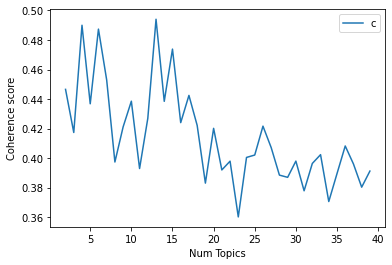

In [30]:
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
#Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4465
Num Topics = 3  has Coherence Value of 0.4173
Num Topics = 4  has Coherence Value of 0.49
Num Topics = 5  has Coherence Value of 0.4368
Num Topics = 6  has Coherence Value of 0.4874
Num Topics = 7  has Coherence Value of 0.4529
Num Topics = 8  has Coherence Value of 0.3973
Num Topics = 9  has Coherence Value of 0.4211
Num Topics = 10  has Coherence Value of 0.4385
Num Topics = 11  has Coherence Value of 0.3929
Num Topics = 12  has Coherence Value of 0.4269
Num Topics = 13  has Coherence Value of 0.4941
Num Topics = 14  has Coherence Value of 0.4384
Num Topics = 15  has Coherence Value of 0.4738
Num Topics = 16  has Coherence Value of 0.424
Num Topics = 17  has Coherence Value of 0.4425
Num Topics = 18  has Coherence Value of 0.4222
Num Topics = 19  has Coherence Value of 0.383
Num Topics = 20  has Coherence Value of 0.4201
Num Topics = 21  has Coherence Value of 0.392
Num Topics = 22  has Coherence Value of 0.3979
Num Topics = 23  has Coher

In [32]:
#Build LDA model
#Num Topics = 13  has Coherence Value of 0.4941

num_topics = 13

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

In [33]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"PER" + 0.074*"ORG" + 0.018*"team" + 0.017*"vivantes" + '
  '0.013*"klinik" + 0.013*"kontakt" + 0.012*"MISC" + 0.011*"medizin" + '
  '0.010*"angebote" + 0.010*"medizinische"'),
 (1,
  '0.001*"PER" + 0.000*"ORG" + 0.000*"MISC" + 0.000*"LOC" + 0.000*"klinik" + '
  '0.000*"patienten" + 0.000*"weiterlesen" + 0.000*"team" + 0.000*"album" + '
  '0.000*"weit"'),
 (2,
  '0.001*"PER" + 0.001*"ORG" + 0.000*"MISC" + 0.000*"LOC" + 0.000*"kontakt" + '
  '0.000*"patienten" + 0.000*"team" + 0.000*"klinik" + 0.000*"medizin" + '
  '0.000*"chirurgie"'),
 (3,
  '0.085*"ORG" + 0.062*"PER" + 0.030*"klinik" + 0.022*"erreichen" + '
  '0.013*"team" + 0.009*"chirurgie" + 0.006*"MISC" + 0.005*"institut" + '
  '0.005*"LOC" + 0.005*"interventionelle"'),
 (4,
  '0.001*"PER" + 0.001*"ORG" + 0.001*"MISC" + 0.000*"LOC" + 0.000*"klinik" + '
  '0.000*"team" + 0.000*"kontakt" + 0.000*"sprechstunden" + 0.000*"patienten" '
  '+ 0.000*"medizinische"'),
 (5,
  '0.107*"PER" + 0.054*"ORG" + 0.024*"MISC" + 0.016*

In [34]:
lda_model

In [35]:
#obtaining documents distribution over topics (vectors for training)
train_vecs = []
for i in range(len(merged_trainDF)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    train_vecs.append(topic_vec)

In [36]:
train_vecs

[[0.00014140498,
  0.00014140274,
  0.00014140274,
  0.00014140448,
  0.00014140274,
  0.30616224,
  0.05170295,
  0.00014140311,
  0.64072084,
  0.00014140457,
  0.0001414033,
  0.00014140278,
  0.00014140432],
 [4.9184287e-05,
  4.9183556e-05,
  4.9183556e-05,
  4.918407e-05,
  4.9183556e-05,
  0.7814472,
  0.08221392,
  4.9183625e-05,
  4.9184313e-05,
  4.918441e-05,
  4.918376e-05,
  4.9183574e-05,
  0.13584712],
 [0.00013037976,
  0.00013037809,
  0.00013037809,
  0.00013037918,
  0.00013037809,
  0.99843544,
  0.00013037969,
  0.00013037813,
  0.00013037953,
  0.000130379,
  0.0001303786,
  0.00013037812,
  0.00013038033],
 [0.0002828077,
  0.0002828054,
  0.0002828054,
  0.00028280698,
  0.0002828054,
  0.9966063,
  0.00028280998,
  0.0002828055,
  0.00028280815,
  0.00028280672,
  0.0002828059,
  0.00028280547,
  0.00028280765],
 [0.00026164623,
  0.00026164312,
  0.00026164312,
  0.00026164527,
  0.00026164312,
  0.9968602,
  0.00026164658,
  0.00026164326,
  0.00026164606,
  

In [47]:
#oversapling method for imbalanced classes (stratification)
oversample = SMOTE()
X, y = oversample.fit_resample(train_vecs, merged_trainDF.label)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
#prepairing data for lightgbm classifier
train_data = lightgbm.Dataset(data=X, label=y)

In [49]:
#lightgbm classifier evaluation function
n_estimators=10000
learning_rate=0.05
n_folds=5
random_seed=6

def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lightgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])

In [50]:
#lightgbm hyperparameters for optimization
lgb_bounds = {'num_leaves': (24, 45),
              'feature_fraction': (0.1, 0.9),
              'bagging_fraction': (0.8, 1),
              'max_depth': (5, 8.99),
              'lambda_l1': (0, 5),
              'lambda_l2': (0, 3),
              'min_split_gain': (0.001, 0.1),
              'min_child_weight': (5, 50)}

In [51]:
#Bayesian optimization, searching for best hyperparameters combination
lgbBO = BayesianOptimization(lgb_eval, lgb_bounds)

In [52]:
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  1        |  0.5677   |  0.8557   |  0.8437   |  4.876    |  1.368    |  8.149    |  7.963    |  0.07817  |  32.51    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  2        |  0.5      |  0.9838   |  0.1737   |  2.743    |  2.914    |  5.894    |  43.06    |  0.05671  |  41.05    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  3        |  0.5639   |  0.9407   |  0.6393   |  3.822    |  0.1354   |  6.661    |  5.906    |  0.0933   |  34.82    |
|  4        |  0.5      |  0.8827   |  0.8538   |  3.595    |  1.896    |  8.135    |  14.43    |  0.003439 |  39.33    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  5        |  0.5      |  0.8473   |  0.8603   |  3.062    |  1.327    |  7.099    |  25.49    |  0.04519  |  27.53    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  6        |  0.6451   |  0.8      |  0.1      |  0.0      |  3.0      |  8.99     |  5.0      |  0.001    |  24.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  7        |  0.5      |  0.8572   |  0.1      |  0.0      |  3.0      |  8.99     |  50.0     |  0.09577  |  24.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  8        |  0.6115   |  1.0      |  0.1      |  5.0      |  3.0      |  5.0      |  5.0      |  0.001    |  24.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  9        |  0.5746   |  0.9166   |  0.5653   |  3.832    |  0.6664   |  8.607    |  5.014    |  0.05508  |  24.22    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.660243 + 0.0669066
[400]	cv_agg's auc: 0.675706 + 0.0693426
|  10       |  0.6807   |  0.8      |  0.9      |  0.0      |  3.0      |  5.0      |  5.0      |  0.1      |  29.59    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.660243 + 0.0669066
[400]	cv_agg's auc: 0.675706 + 0.0693426
|  11       |  0.6807   |  0.8      |  0.9      |  0.0      |  3.0      |  5.0      |  5.0      |  0.1      |  44.7     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  12       |  0.5      |  0.8      |  0.9      |  0.0      |  3.0      |  8.99     |  50.0     |  0.01372  |  45.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.626099 + 0.0867297
|  13       |  0.6315   |  0.8      |  0.9      |  0.0      |  3.0      |  5.0      |  9.135    |  0.1      |  24.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.653179 + 0.0629393
|  14       |  0.6633   |  0.8059   |  0.2119   |  0.2479   |  2.919    |  6.826    |  5.007    |  0.01259  |  38.73    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.654906 + 0.0626174
[400]	cv_agg's auc: 0.672331 + 0.0540913
|  15       |  0.6755   |  0.9985   |  0.6049   |  0.05476  |  2.908    |  8.473    |  5.127    |  0.04329  |  40.73    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  16       |  0.5689   |  0.9839   |  0.8362   |  4.629    |  2.907    |  6.417    |  5.149    |  0.01611  |  42.64    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.669623 + 0.0616953
|  17       |  0.6772   |  0.8457   |  0.549    |  0.2476   |  2.721    |  8.762    |  5.622    |  0.05908  |  31.72    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  18       |  0.5      |  0.8      |  0.9      |  5.0      |  3.0      |  5.0      |  50.0     |  0.001    |  31.57    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.646507 + 0.0654978
|  19       |  0.6577   |  0.9172   |  0.13     |  0.131    |  2.809    |  8.067    |  5.872    |  0.06259  |  44.8     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.637323 + 0.064469
|  20       |  0.6453   |  0.9633   |  0.5955   |  0.7574   |  2.859    |  7.127    |  5.193    |  0.0805   |  29.94    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  21       |  0.5      |  0.8      |  0.9      |  0.0      |  0.0      |  5.0      |  40.17    |  0.001    |  24.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  22       |  0.5      |  0.8      |  0.9      |  5.0      |  3.0      |  8.99     |  37.58    |  0.1      |  24.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  23       |  0.5      |  0.8      |  0.9      |  0.0      |  3.0      |  8.99     |  31.55    |  0.1      |  45.0     |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  24       |  0.5      |  0.8      |  0.9      |  0.0      |  0.0      |  8.99     |  44.7     |  0.001    |  34.61    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  25       |  0.5      |  0.9026   |  0.242    |  4.806    |  0.02934  |  6.946    |  49.21    |  0.05651  |  44.89    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  26       |  0.6509   |  0.842    |  0.8401   |  1.286    |  0.03153  |  7.958    |  5.075    |  0.04336  |  43.89    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.663265 + 0.0727977
|  27       |  0.6719   |  0.9498   |  0.7278   |  0.1873   |  0.9361   |  8.923    |  6.613    |  0.07471  |  34.03    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.669152 + 0.0796713
[400]	cv_agg's auc: 0.682182 + 0.0754739
|  28       |  0.6867   |  0.9017   |  0.8115   |  0.02935  |  2.587    |  8.555    |  6.54     |  0.08466  |  34.87    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  29       |  0.6187   |  0.8      |  0.9      |  0.0      |  2.595    |  8.99     |  13.15    |  0.1      |  29.46    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.653336 + 0.0669142
[400]	cv_agg's auc: 0.667936 + 0.0591928
[600]	cv_agg's auc: 0.675549 + 0.0535284
|  30       |  0.6798   |  0.97     |  0.3157   |  0.3213   |  1.862    |  8.949    |  5.152    |  0.003371 |  34.85    |


In [53]:
params = lgbBO.max['params']

In [54]:
#best hyperparameters combination
params

{'bagging_fraction': 0.9017306814473877,
 'feature_fraction': 0.8115457221149905,
 'lambda_l1': 0.02934970636566392,
 'lambda_l2': 2.5872437273650317,
 'max_depth': 8.555247127977145,
 'min_child_weight': 6.5395828466960175,
 'min_split_gain': 0.08465945192810721,
 'num_leaves': 34.872893321194695}

In [60]:
params['num_leaves'] = int(round(params['num_leaves']))
params['max_depth'] = int(round(params['max_depth']))

In [61]:
#splitting dataset
x, x_test, y, y_test = train_test_split(train_vecs, merged_trainDF.label, test_size=0.2, random_state=42, stratify=merged_trainDF.label)

In [62]:
train_data = lightgbm.Dataset(x, label=y)
test_data = lightgbm.Dataset(x_test, label=y_test)

In [63]:
model = lightgbm.train(params, train_data)

In [65]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = precision_recall_curve(target, predicted)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    return optimal_threshold

In [66]:
y_test_predicted = model.predict(x_test)

In [69]:
cutoff_ = find_optimal_cutoff(y_test, y_test_predicted)

In [68]:
cutoff_

0.4514573705095071

In [70]:
#apply the same pipeline to test data
testDF = pd.read_csv("datasciene_hiring/test.csv")

In [71]:
testDF.head()

url  doc_id
0  http://chirurgie-goettingen.de/medizinische-ve...       0
1  http://evkb.de/kliniken-zentren/chirurgie/allg...       2
2  http://krebszentrum.kreiskliniken-reutlingen.d...       7
3  http://marienhospital-buer.de/mhb-av-chirurgie...      15
4  http://marienhospital-buer.de/mhb-av-chirurgie...      16

In [72]:
merged_testDF = testDF.merge(html_textDF, how='inner', left_on="doc_id", right_on="doc_id")[['text']]

In [73]:
merged_testDF

text
0           Klinik für Allgemein-, Viszeral- und K...
1                          Notfall | Zentrale Nota...
2                direkt zum Inhalt .  zur Navigati...
3               Sankt Marien-Hospital Buer GmbH  E...
4               Sankt Marien-Hospital Buer GmbH  E...
5              Onkologisches Zentrum        Menü  ...
6            Springe direkt zum Inhalt (Drücke Ent...
7            Springe direkt zum Inhalt (Drücke Ent...
8                   Notfall Menu Suchen Patienten ...
9                   Notfall Menu Suchen Patienten ...
10           Zur Unternehmensseite  Unsere Angebot...
11                       Nachrichten Chirurgie Dir...
12     Um unseren Webauftritt für Sie optimal gest...
13     Um unseren Webauftritt für Sie optimal gest...
14                A    A    A                     ...
15                    Über uns    Einweiser    Kar...
16                                           Notfa...
17        Skip to main content Zentrum für Medizin...
18         Anfahrt Ausbildung Karriere English    ...
19                 Stationäre Versorgung Allgemein...
20          Krankenhäuser  Altenhilfe  Kinder- & J...
21              A  A  A              Kontakt     J...
22                     Auf dieser Website werden C...
23                     Auf dieser Website werden C...
24  Skip to main content hjk  Die Einrichtungen de...
25            Suche           Wir über uns    Das ...
26                         Home    Infos für Patie...
27     https://www.josephstift-dresden.de/ Pressem...
28            Toggle navigation      Klinikum Ludw...
29                     Kontakt Sitemap         Not...
30           Toggle navigation               Klini...
31           Toggle navigation               Klini...
32           Toggle navigation               Klini...
33             Kreiskrankenhaus Gummersbach  •  Wi...
34      Standorte & Kontakt Aktuelles Ihre Meinung...
35                                                ...
36                      Krankenhaus  Malteser Kran...
37  Skip to main content mjg  Die Einrichtungen de...
38       Umfrage zur Nutzung unserer Internetseite...
39                               PR & Kommunikatio...
40      Direkt zum Inhalt           IM NOTFALL    ...
41        Über Uns Jobs & Karriere Medizin Kinder ...
42  Germany Menu Navigation Produkte & Services Zu...
43                 Universitätsklinikum Augsburg  ...
44        English   ألعربية   русский          Not...
45         Möglicherweise versuchen Sie, mit einem...
46                                A-    A    A+   ...
47                                                ...

In [74]:
texts_set = merged_testDF.text.values.tolist()
tokens_set = list(sent_to_words(texts_set))
data_words_nostops = remove_stopwords(tokens_set)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [75]:
test_vecs = []
for i in range(len(merged_testDF)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    test_vecs.append(topic_vec)

In [76]:
test_vecs

[[0.0002936053,
  0.00029359953,
  0.00029359953,
  0.00029360518,
  0.00029359953,
  0.40348908,
  0.25839186,
  0.0042168223,
  0.28672394,
  0.03308698,
  0.00029360043,
  0.0002935996,
  0.012036074],
 [0.020816127,
  0.000102838334,
  0.000102838334,
  0.000102839556,
  0.000102838334,
  0.39455298,
  0.30183214,
  0.0014668775,
  0.21415958,
  0.000102839585,
  0.00010283892,
  0.000102838356,
  0.06645241],
 [0.026684182,
  0.00015353909,
  0.00015353909,
  0.00015354132,
  0.00015353909,
  0.44700962,
  0.21488376,
  0.00015353937,
  0.23701525,
  0.00015354149,
  0.00015353969,
  0.00015353912,
  0.07317886],
 [0.9985207,
  0.00012327418,
  0.00012327418,
  0.00012327568,
  0.00012327418,
  0.00012327598,
  0.00012327592,
  0.00012327428,
  0.0001232758,
  0.00012327587,
  0.00012327448,
  0.0001232742,
  0.00012327531],
 [0.9985207,
  0.00012327418,
  0.00012327418,
  0.00012327568,
  0.00012327418,
  0.00012327706,
  0.00012327588,
  0.00012327428,
  0.0001232758,
  0.000123

In [77]:
y_pred = model.predict(test_vecs)

In [78]:
testDF['prediction'] = [1 if y>cutoff_ else 0 for y in y_pred]

In [79]:
testDF.drop("url", axis=1).to_csv("submisson.csv")